# Week 8 - Link Analysis

This week, we are going to work with link analysis

In [4]:
import networkx as nx
import scipy as sp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tabulate
import tqdm

import sys
sys.path.append('./utilities')
from utilities.load_data import load_dblp_citations

Below, we have included some code to plot the karate graph.

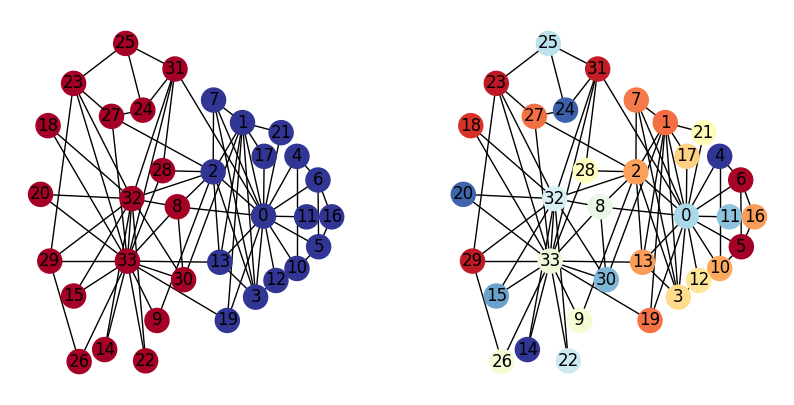

In [5]:
def plot_karate(G, pr=[], ax=None, cmap=plt.get_cmap('RdYlBu')): 
    fixed_positions = {0:(10.74,4.07),1:(9.76,6.48),2:(8.39,5.21),3:(10.37,1.98),4:(12.30,5.61),5:(13.31,3.28),6:(13.28,5.00),7:(8.41,7.06),8:(6.72,4.31),9:(5.77,1.38),10:(12.30,2.72),11:(12.75,4.05),12:(11.32,2.41),13:(8.70,2.88),14:(3.33,0.63),15:(1.88,2.01),16:(13.92,4.05),17:(10.77,5.61),18:(0.69,6.40),19:(9.05,1.38),20:(0.34,4.63),21:(11.56,6.22),22:(5.24,0.34),23:(1.88,7.49),24:(5.11,6.80),25:(4.31,8.52),26:(2.14,0.32),27:(3.65,6.64),28:(6.03,5.24),29:(0.77,2.91),30:(7.01,2.43),31:(6.61,7.86),32:(4.60,4.52),33:(4.39,2.91)}
    if len(pr) :
        nx.draw(G, with_labels=True, pos=fixed_positions, ax=ax, cmap=cmap, node_color=pr)
    else : 
        nx.draw(G, with_labels=True, pos=fixed_positions, ax=ax)

G = nx.karate_club_graph()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
magic_cut = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_karate(G, magic_cut, ax=ax[0])
plot_karate(G, np.random.rand(G.order()), ax=ax[1])

## Exercise 1 - Random walks and PageRank

Random walks are tightly connected to the Pagerank as a limit of convergence in performing random walks on a graph. 

In this theoretical exercise we will reason about PageRank and its properties. Remember that the Personalized Pagerank in a undirected graph can be experssed by the equation 
$$
\mathbf{r} = \alpha M\mathbf{r} - (1-\alpha)\mathbf{p} 
$$
where $M = A^\top \Delta^{-1}$ is the transition matrix, $\mathbf{p}$ is called the restart vector and represents the starting nodes of the random walk where the walker will jump back with probability $(1-\alpha)$. 

Let us assume $\alpha = 0.85$ and $\mathbf{p} = \frac{1}{n}\mathbf{1}_n$ is uniformly distributed where $\mathbf{1}_n$ is the $n$-dimensional vectors with all 1s. 

1. (Warm up) Argue why $M = A^\top \Delta^{-1}$ makes sense as a transition matrix. 

We get probabilities to go from node j to node i in the column 

2. What is the PageRank of a circle of $n$ nodes?

$\frac{1}{n}$

3. A [path graph](https://en.wikipedia.org/wiki/Path_graph) is a graph where each node is connected to the consecutive. What is the PageRank with 3 nodes when $\alpha=1$? 
**Hint**: Remember that the elements in the PageRank vector sum to 1 (it's a distribution over nodes). 

If the path graph is undirected, then the middel node might be the most important. If directed, then its the outer ones. 

4. Consider a complete directed bipartite graph (with self loops) consisting of 3 hubs and 2 authorities:  
![hubs_and_authorities](graphics/bipartite_1.png)
    1. Write the adjacency matrix of the system, and normalize it for use with the PageRank algorithm.
    2. What is the PageRank score of the nodes in the system? Provide both an analytical proof and an intuitive explanation. Assume no damping factor.
    3. Now add a link from one of the authorities to one of the hubs. What is the PageRank score of the nodes now? Provide both an analytical proof and an intuitive explanation. 


5. Prove the following statement:
In an undirected and connected graph, $G(V,E)$, the stationary distribution of a random walk is proportional to the nodes' degrees.

In other words, for a transition matrix $ M $, in which 
$$
    M(u, v) = \left\{ 
    \begin{matrix}
    \frac{1}{d_u}&\text{, if }(u, v) \in E\\ 
    0&\text{, otherwise}
    \end{matrix}
    \right.
$$
and a stationary distribution $\pi$, such that $\pi = M\pi$, prove that probability $\pi_i$ is proportional to $d_i$, the number of edges incident on note $i$.


## Exercise 2 - Implementing PageRank

1. Provide an implementation of PageRank using the Power Iteration method below and run it on the karate graph, and the graphs discussed in exercise 1.
2. Check your code below. Why does the method fail for two of the graphs when $\alpha = 1$?

In [68]:
from networkx.algorithms import bipartite

# Tolerance is the sum of the absolute differences among the pagerank vectors in consequent iterations
# The iteration stops is the the differences are less than the tolerance
def my_pagerank(G : nx.Graph, alpha = 0.85, p = None, max_iter = 100, tol=1e-06) : 
    A = nx.adjacency_matrix(G)
    n = G.number_of_nodes()
    r = np.full(n, 1/n)
    degree_v = [val for (node, val) in G.degree()]
    degree_m = np.zeros((G.number_of_nodes(),G.number_of_nodes()))
    np.fill_diagonal(degree_m, degree_v)

    M = A.T @ np.linalg.inv(degree_m)

    if p is None : 
        p = np.full(n, 1/n)

    r_prev = np.zeros(n)
    t = 0
    while (np.linalg.norm(r-r_prev) >= tol and t < max_iter):
        r_prev = r
        r = alpha * (M.T @ r_prev) + (1 - alpha) * p
        t += 1
        #r = M.T @ r_prev


    ### YOUR CODE HERE
    ### YOUR CODE HERE
    return r


# simple helper function to simplify comparing nx pagerank with your own pagerank
def change_nx_format(nx_pagerank):
    keys = sorted(nx_pagerank.keys())
    return np.array([nx_pagerank[i] for i in keys])
    
    
alpha=.85  # Try different values (including 1)

G_karate = nx.karate_club_graph()
print('Pagerank karate graph')
print("nx:\n", change_nx_format(nx.pagerank(G_karate, alpha=alpha)))
print("my:\n", my_pagerank(G_karate, alpha=alpha))
print()

G_circle = nx.circulant_graph(10, [1])
print('Pagerank circulant graph')
print("nx:\n", change_nx_format(nx.pagerank(G_circle, alpha=alpha)))
print("my:\n", my_pagerank(G_circle, alpha=alpha))
print()

G_path = nx.path_graph(3)
print('Pagerank path graph')
print("nx:\n", change_nx_format(nx.pagerank(G_path, alpha=alpha)))
print("my:\n", my_pagerank(G_path, alpha=alpha, max_iter=1000))
print()

G_biparte = nx.DiGraph()
G_biparte.add_edges_from([(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (1, 4), (1, 5), (2, 4), (2, 5), (3, 4), (3, 5)])
print('Pagerank hubs and authorities graph')
print("nx:\n", change_nx_format(nx.pagerank(G_biparte, alpha=alpha)))
print("my:\n", my_pagerank(G_biparte, alpha=alpha, max_iter=1000))

print() 
print("Matrix solve with tiny damping")
A = np.array(nx.adjacency_matrix(G_biparte).todense())
W = (A / np.sum(A, 1, keepdims=True)).T

d = 0.99
n = G_biparte.order()

print("damping factor: %.2f" % d)
P = np.linalg.inv(np.eye(n) - d * W) @ ((1-d) * np.ones((n, 1)) / n)
print(P)

Pagerank karate graph
nx:
 [0.08850807 0.05741484 0.06276686 0.03721208 0.02050398 0.03381044
 0.03152901 0.02646462 0.03338156 0.00946322 0.02068902 0.00978569
 0.01147487 0.03347419 0.0129416  0.01637633 0.0167554  0.00967727
 0.00954486 0.01307752 0.01122424 0.01136015 0.0129606  0.04114597
 0.01663437 0.02867296 0.01524039 0.02723536 0.01447852 0.02827181
 0.02303184 0.04198549 0.07592644 0.09698042]
my:
 [1.73257890e+41 2.16880930e+41 2.65938224e+41 1.97972176e+41
 1.33520788e+41 1.80360961e+41 1.72504159e+41 2.26291883e+41
 3.21138953e+41 1.48616131e+41 1.35343542e+41 1.63833552e+41
 1.20907343e+41 2.52885581e+41 2.97075475e+41 4.03779518e+41
 1.66835575e+41 8.87918031e+40 1.70161187e+41 1.17549629e+41
 2.43723454e+41 1.22972422e+41 2.86970352e+41 7.02430887e+41
 4.58089352e+41 8.87888279e+41 4.05626073e+41 4.78316403e+41
 2.47766136e+41 4.74175855e+41 2.85312019e+41 5.74619388e+41
 4.02644732e+41 3.38526269e+41]

Pagerank circulant graph
nx:
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1

 ## Exercise 3 - HITS
 Your task is to implement your own version of the HITS algorithm.
 You may consult this [link](https://www.geeksforgeeks.org/hyperlink-induced-topic-search-hits-algorithm-using-networxx-module-python/).
 
 Apply your HITS algorithm on the karate network, to discover hubs and authorities.
 
 Make sure to normalize your matrix after every iteration, to ensure that values converge. (Be aware that nx normalizes differently from the link (using just the sum of hubs or authorities), so depending on how you implement normalization, you might not get the same result as nx.hits())

In [111]:
def hits(G : nx.Graph, k=50):
    n = G.number_of_nodes()
    hubs = np.full(n, 1/np.sqrt(n))
    auths = np.full(n, 1/np.sqrt(n))

    t = 0
    while(k > t):
        hubs_n = np.zeros(n)
        auths_n = np.zeros(n)
        for u,v in G.edges():

            auths_n[v] += hubs[u] 
            hubs_n[u] += auths[v]


        hubs = hubs_n / np.sum(hubs_n)
        auths = auths_n / np.sum(auths_n)
        
        t += 1
    ### YOUR CODE HERE
    
    ### YOUR CODE HERE
    
    return hubs, auths
    

In [120]:
import time
G_test = G # G1
t0 = time.time()
h1, a1 = hits(G_test, k=50)
t1 = time.time() - t0
print("h", h1)
print("a", a1)
print(t1)

h [0.06900112 0.04270668 0.06066027 0.0181607  0.00636016 0.00662759
 0.00026744 0.         0.05810077 0.03018408 0.         0.
 0.         0.03018408 0.05419078 0.05419078 0.         0.
 0.05419078 0.03018408 0.05419078 0.         0.05419078 0.06665195
 0.01328277 0.00472912 0.03409161 0.03018408 0.0349132  0.05419078
 0.05419078 0.05419078 0.03018408 0.        ]
a [0.         0.01931593 0.03121195 0.04747248 0.01931593 0.01931593
 0.02299592 0.05253291 0.03557646 0.01626053 0.02299592 0.01931593
 0.02437637 0.05253291 0.         0.         0.00195504 0.03121195
 0.         0.03121195 0.         0.03121195 0.         0.
 0.         0.0207593  0.         0.03701983 0.01626053 0.02599598
 0.02691816 0.0332117  0.16030527 0.2007192 ]
0.014022350311279297


In [116]:
t0 = time.time()
h, a = nx.hits(G_test)
t  = time.time() - t0
print("h", h)
print("a", a)
print(t)

h {0: 0.0668777878017573, 1: 0.06460820139870788, 2: 0.07720593702807284, 3: 0.04251538956587161, 4: 0.011920567930085271, 5: 0.014437084548291434, 6: 0.014227285240639476, 7: 0.03820430110403424, 8: 0.05287480008426347, 9: 0.010749022088966229, 10: 0.009813389569912076, 11: 0.009251077981447949, 12: 0.008964766141133604, 13: 0.05149077757366967, 14: 0.017029873773128704, 15: 0.024218978747837485, 16: 0.003965088094607894, 17: 0.009146428782312348, 18: 0.010469361240848756, 19: 0.015720024731013783, 20: 0.013435321285774316, 21: 0.012125472243659396, 22: 0.017344169994343118, 23: 0.0466855250206694, 24: 0.010930126255860845, 25: 0.02624619804070176, 26: 0.012553159895365174, 27: 0.031620548465526754, 28: 0.018444663444097793, 29: 0.02908332365104132, 30: 0.033896584340598744, 31: 0.044846896017269135, 32: 0.07114077395376942, 33: 0.07795709396472078}
a {0: 0.06687778780175728, 1: 0.06460820139870792, 2: 0.07720593702807284, 3: 0.04251538956587161, 4: 0.011920567930085273, 5: 0.01443708

  Node #         Hub1      Hub_nx    Node #        Aut1      Aut_nx
--------  -----------  ----------  --------  ----------  ----------
       0  0.0690025    0.0668778         33  0.208579    0.0779571
      23  0.0666517    0.0466855         32  0.165913    0.0711408
       2  0.0606607    0.0772059         13  0.0511732   0.0514908
       8  0.0581006    0.0528748          7  0.0511732   0.0382043
      29  0.0541905    0.0290833          3  0.0462938   0.0425154
      30  0.0541905    0.0338966         27  0.0377069   0.0316205
      14  0.0541905    0.0170299          8  0.0348196   0.0528748
      15  0.0541905    0.024219          31  0.0327348   0.0448469
      31  0.0541905    0.0448469         17  0.030016    0.00914643
      22  0.0541905    0.0173442         19  0.030016    0.01572
      18  0.0541905    0.0104694         21  0.030016    0.0121255
      20  0.0541905    0.0134353          2  0.030016    0.0772059
       1  0.0427074    0.0646082         30  0.0270478   0.03

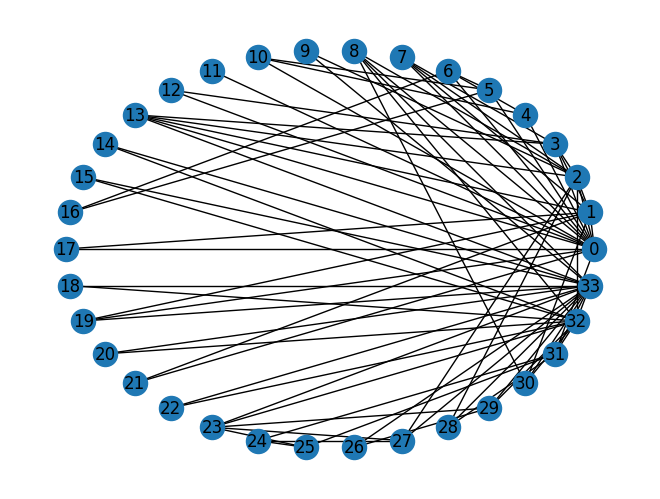

In [117]:

if isinstance(h, dict):
    h = [h[n] for n in G_test]
    a = [a[n] for n in G_test]

T = np.stack([h1, h, a1, a]).T

if G_test.order() < 50: 
    nx.draw(G_test, pos=nx.circular_layout(G_test), labels={k: k for k in G_test.nodes})

order = np.argsort(T[:,0])[::-1][:50]
T1 = T[order,:2]

order2 = np.argsort(T[:,2])[::-1][:50]
T2 = T[order2,2:]
T = np.concatenate([order.reshape(-1, 1), T1, order2.reshape(-1, 1), T2], axis=1)
print(tabulate.tabulate(T, headers=['Node #', 'Hub1', 'Hub_nx', 'Node #', 'Aut1', 'Aut_nx']))

In [121]:
algorithms = [nx.hits, hits]

ns = [100, 200, 400, 800, 1600, 3200]

graph_generators = [
    lambda n: nx.fast_gnp_random_graph(n, 0.04),
    lambda n: nx.gnm_random_graph(n, n*4, directed=True),
    lambda n: nx.erdos_renyi_graph(n, 0.04, directed=True),
    lambda n: nx.dual_barabasi_albert_graph(n, 10, 10, 0.4),
]
import time

times = []
from tqdm import tqdm
for n in tqdm(ns):
    graphs = [gen(n) for gen in graph_generators]
    running_time = []
    for algo in algorithms:
        t = []
        for g in graphs:
            t0 = time.time()
            h, a = algo(g)
            t.append(time.time() - t0)
        running_time.append(sum(t) / len(graphs))
    times.append(running_time)

100%|██████████| 6/6 [00:51<00:00,  8.64s/it]


----------  ---------
0.00433224  0.0534859
0.00788426  0.0971695
0.0124127   0.172443
0.0674022   0.594049
0.151802    2.16541
0.563628    8.19047
----------  ---------


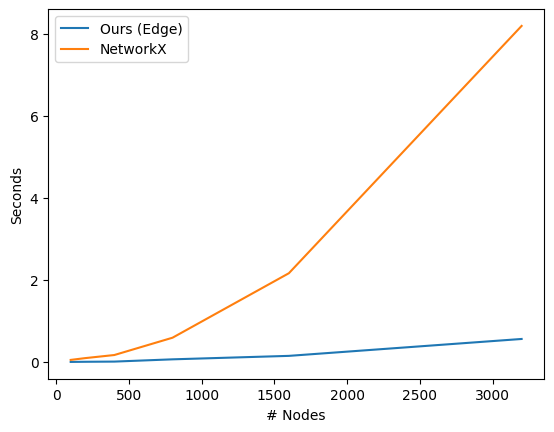

In [122]:
print(tabulate.tabulate(times))
times = np.array(times)
fig, ax = plt.subplots(1, 1)
ax.plot(ns, times[:,0], label="Ours (Edge)")
ax.plot(ns, times[:,1], label="NetworkX")
ax.set_xlabel("# Nodes")
ax.set_ylabel("Seconds")
ax.legend()

## Exercise 4 - HITS vs PageRank

Download the `cit-DBLP` dataset from the [citation dataset collection](http://networkrepository.com/cit.php) in the [Network Repository](http://networkrepository.com/networks.php).

1. Apply the PageRank and HITS algorithms on the `cit-DBLP` dataset.
2. HITS hubs value, HITS authorities value, PageRank value. Calculate the [Kullback-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and  [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) between each pair of distribution. What do you observe?


$$
{\displaystyle D_{\text{KL}}(P\parallel Q)=-\sum _{x\in {\mathcal {X}}}P(x)\log \left({\frac {Q(x)}{P(x)}}\right)}
$$

$$
{D_{\text{JS}}(P\parallel Q)=\frac{1}{2} D_{\text{KL}}(P\parallel M)+{\frac {1}{2}}D_{\text{KL}}(Q\parallel M)}\\
\text{where }M = \frac{1}{2}(P + Q)
$$

In [ ]:
# Method will load a list of all pairs of nodes that are 
# connected to each other by an edge.
# Additionally, is will load precomputed positions for plotting nodes.
# It is, however, not a pretty plot but the computation is fun (also plotting will take forever and potentially melt your pc)
edges, pos = load_dblp_citations()
print("Number of edges: ", len(edges))
print("Number of nodes: ", len(pos))
print("Position example: ", pos[1])

In [ ]:
# Full cit-DBLP graph. Very large and time-consuming.
G = nx.DiGraph()
G.add_edges_from(edges)

# Small test graph ideal for testing while implementing
G_test = nx.DiGraph()
G_test.add_edges_from([(0, 3), (1, 2), (1, 4), (2, 0), 
                  (3, 2), (4, 3), (4, 1), (4, 5), 
                  (4, 2), (5, 2), (5, 7), (6, 0),  
                  (6, 2), (7, 0)])
# nx.draw(G_test)


In [ ]:
def kl(p1, p2): 
    
    ### TODO: Implement KL divergence
    
    return 0

def js(p1, p2):
    
    ### TODO: Implement JS divergence
    
    return 0

In [ ]:
### Compare authority, hubs and pagerank using kl and js divergence
p = my_pagerank(G_test)
h, a = hits(G_test)

# p = my_pagerank(G)
# h, a = hits(G)

divergences = [
    ['D_KL (P, A)', kl(p, a), 'D_KL(A, P)', kl(a, p), 'D_JS(A, P)', js(a, p)],
    ['D_KL (P, H)', kl(p, h), 'D_KL(H, P)', kl(h, p), 'D_JS(H, P)', js(h, p)],
    ['D_KL (H, A)', kl(h, a), 'D_KL(A, H)', kl(a, h), 'D_JS(A, H)', js(a, h)],
]

print(tabulate.tabulate(divergences))


## Exercise 5 - PageRank problems

In this exercise, we study the effect of link farms on PageRank $\alpha = 0.85$ and HITS

1. Add a new node with an edge from and to the node with the lowest PageRank of the DBLP graph. Add 100 fake nodes with edges to and from this new node. Run PageRank and HITS and notice what changes. You may want to start with a smaller test-graph and fewer added nodes to speed up computation while implementing. 
2. Instead of the node with the lowest PageRank, connect the above node to the node with heighest PageRank - What do you notice? Why is that happening? 
3. Keep adding fake nodes until the new node has the highest PageRank and Authority score. 

In [ ]:


# G = nx.DiGraph()
# G.add_edges_from(edges)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

G = G_test.copy()
nx.draw(G, with_labels=True, ax=ax[0])

p = my_pagerank(G)

print(p)

lowest = np.argmin(p)
highest = np.argmax(p)
print(lowest, p[lowest])
print(highest, p[highest])

num_nodes = G.number_of_nodes()
# print(num_nodes)


print("Lowest Pagerank after adding 10 fake nodes")
## YOUR CODE TO ADD FAKE NODES
## YOUR CODE TO ADD FAKE NODES
    
nx.draw(G, with_labels=True, ax=ax[1])

p = nx.pagerank(G)

print(lowest, p[lowest])

print("Highest Pagerank after adding 10 fake nodes")
G = G_test.copy()

## YOUR CODE TO ADD FAKE NODES
## YOUR CODE TO ADD FAKE NODES

nx.draw(G, with_labels=True, ax=ax[2])

p = nx.pagerank(G)
print(highest, p[highest])




